Setup and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
import os

# 1. Load Data
csv_path = 'Data/cleaned_fires_nepal.csv'
df = pd.read_csv(csv_path)

# 2. Prepare Coordinates for ML
# K-Means uses simple Lat/Lon (Euclidean) - usually bad for maps
X_simple = df[['latitude', 'longitude']]

# DBSCAN uses Radians (Haversine) - accounts for Earth's curve
# We created these columns in step 1
X_rad = df[['lat_rad', 'lon_rad']]

print(f"Ready to cluster {len(df)} fire points.")

Ready to cluster 11291 fire points.


Expirement 1 : K-Means (The Baseline)

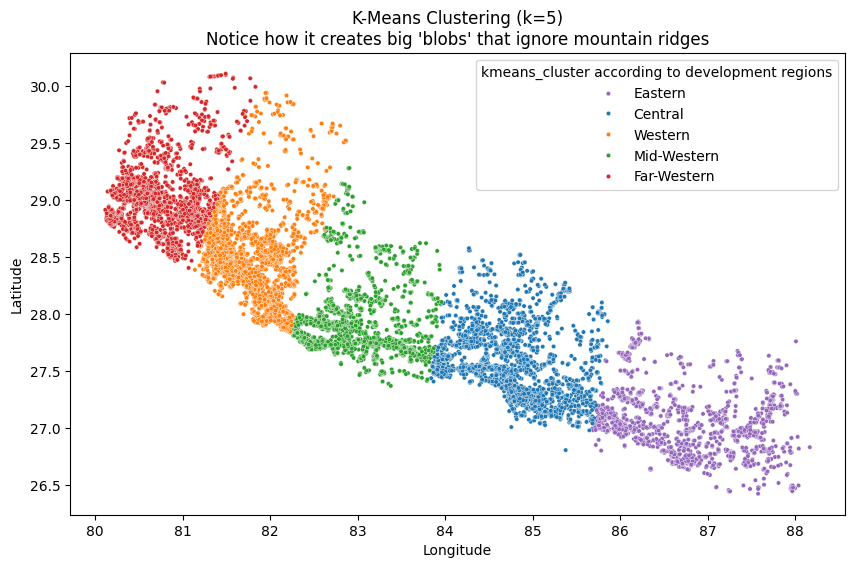

In [2]:
# --- K-MEANS CLUSTERING ---
# We arbitrarily pick 5 clusters (regions)
kmeans = KMeans(n_clusters=5, random_state=42)
df['kmeans_cluster'] = kmeans.fit_predict(X_simple)

# Visualize
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='longitude', y='latitude', hue='kmeans_cluster', palette='tab10', s=10)
plt.title("K-Means Clustering (k=5)\nNotice how it creates big 'blobs' that ignore mountain ridges")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
new_labels = ['Eastern', 'Central', 'Western', 'Mid-Western', 'Far-Western']
plt.legend(title='kmeans_cluster according to development regions', labels=new_labels)
plt.show()

Experiment 2 - DBSCAN (The Solution)

In [3]:
# --- DBSCAN CLUSTERING ---
# Parameters:
# eps: The maximum distance between two fires to be considered neighbors (in radians)
# min_samples: Minimum fires required to form a "Hotspot" (Cluster)

kms_per_radian = 6371.0088
epsilon_dist = 2.0 # We want a 2km radius
epsilon_rad = epsilon_dist / kms_per_radian

# Run the Algorithm
db = DBSCAN(eps=epsilon_rad, min_samples=15, metric='haversine', algorithm='ball_tree')
df['dbscan_cluster'] = db.fit_predict(X_rad)

# Count results
n_clusters = len(set(df['dbscan_cluster'])) - (1 if -1 in df['dbscan_cluster'] else 0)
n_noise = list(df['dbscan_cluster']).count(-1)

print(f"Estimated number of Hotspots: {n_clusters}")
print(f"Noise points (isolated fires): {n_noise}")

Estimated number of Hotspots: 55
Noise points (isolated fires): 8802


Visualize the Hotspots

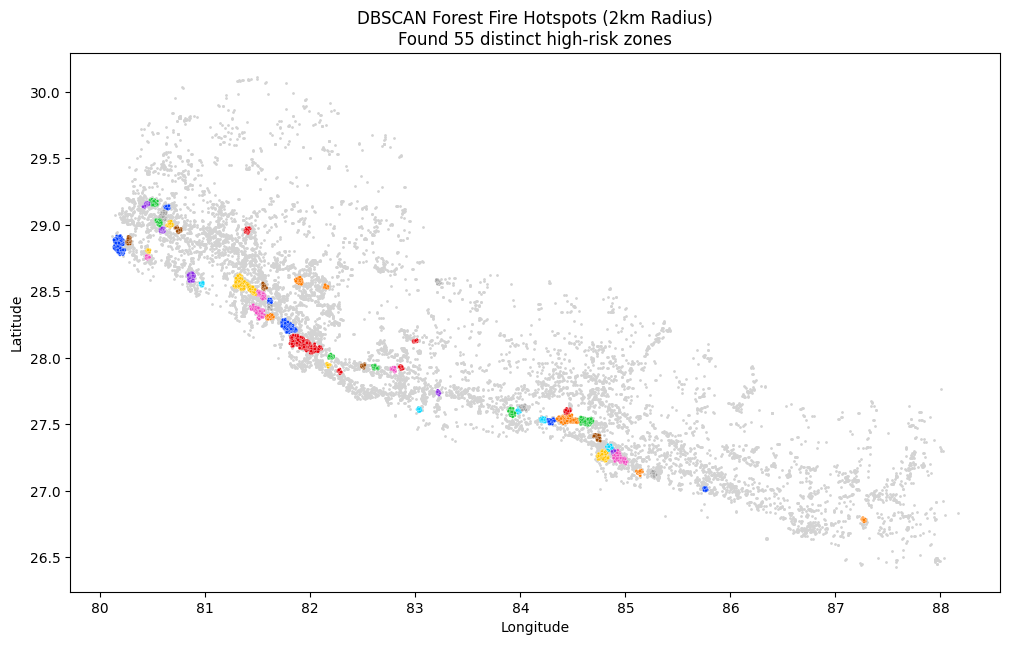

In [4]:
plt.figure(figsize=(12, 7))

# 1. Plot Noise (Cluster -1) as small grey dots
noise_data = df[df['dbscan_cluster'] == -1]
plt.scatter(noise_data['longitude'], noise_data['latitude'], c='lightgrey', s=1, label='Noise (Scattered Fires)')

# 2. Plot Clusters (Hotspots) as colored dots
cluster_data = df[df['dbscan_cluster'] != -1]
sns.scatterplot(data=cluster_data, x='longitude', y='latitude', hue='dbscan_cluster', palette='bright', s=5, legend=False)

plt.title(f"DBSCAN Forest Fire Hotspots (2km Radius)\nFound {n_clusters} distinct high-risk zones")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

Experiment 3 - HDBSCAN (The Advance Method)

In [5]:
from sklearn.cluster import HDBSCAN

# --- HDBSCAN CLUSTERING ---
# Unlike DBSCAN, we don't guess the distance (eps).
# We only tell it: "A cluster must have at least 15 fires."
# It figures out the varying densities automatically.

hdb = HDBSCAN(min_cluster_size=15, metric='haversine')
df['hdbscan_cluster'] = hdb.fit_predict(X_rad)

# Count results
# Note: HDBSCAN also uses -1 for noise
n_clusters_hdb = len(set(df['hdbscan_cluster'])) - (1 if -1 in df['hdbscan_cluster'] else 0)
n_noise_hdb = list(df['hdbscan_cluster']).count(-1)


print(f"HDBSCAN Hotspots: {n_clusters_hdb}")
print(f"HDBSCAN Noise: {n_noise_hdb} (Should be lower)")

HDBSCAN Hotspots: 97
HDBSCAN Noise: 4138 (Should be lower)


Visualize the Hotspots

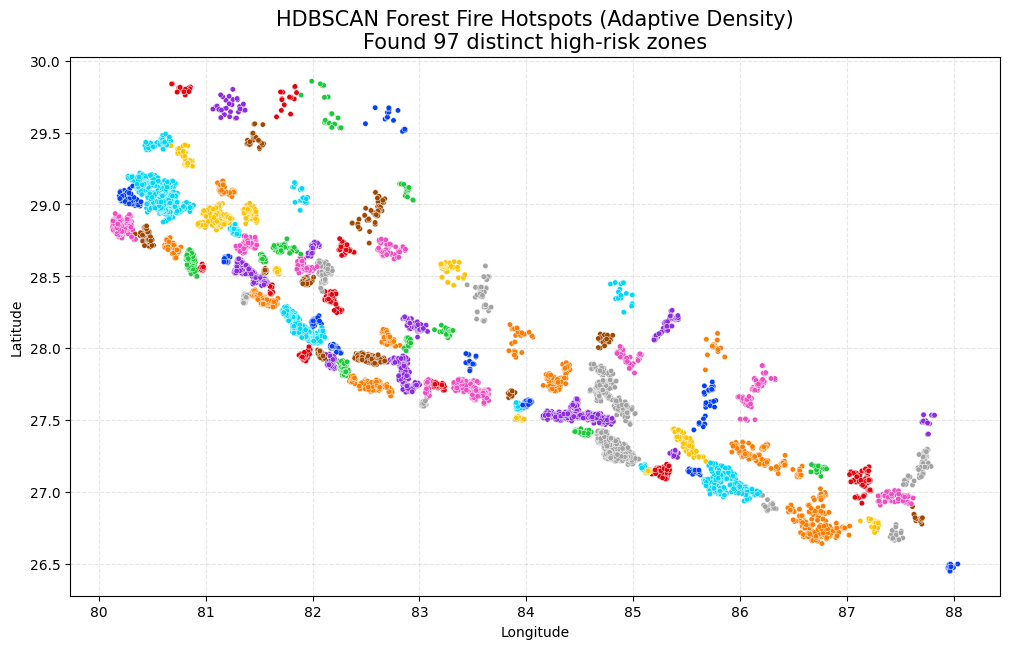

In [6]:
# --- FINAL HDBSCAN MAP ---
plt.figure(figsize=(12, 7))

# 1. Filter out the noise (-1) so we only see the actual clusters
cluster_data_hdb = df[df['hdbscan_cluster'] != -1]

# 2. Plot the clusters
# We use 'bright' palette so every cluster looks distinct
sns.scatterplot(data=cluster_data_hdb, x='longitude', y='latitude', 
                hue='hdbscan_cluster', palette='bright', s=15, legend=False)

# 3. Formatting
plt.title(f"HDBSCAN Forest Fire Hotspots (Adaptive Density)\nFound {n_clusters_hdb} distinct high-risk zones", fontsize=15)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Add a subtle grid to make it look professional
plt.grid(True, linestyle='--', alpha=0.3)

plt.show()

The 3-Way Statistical Comparison

In [7]:
# --- FULL COMPARISON (K-Means vs DBSCAN vs HDBSCAN) ---

# 1. K-Means Metrics
# K-Means doesn't have "noise" (it forces every point into a cluster)
n_clusters_kmeans = len(set(df['kmeans_cluster']))
n_noise_kmeans = 0 

# 2. DBSCAN Metrics
n_clusters_db = len(set(df['dbscan_cluster'])) - (1 if -1 in df['dbscan_cluster'] else 0)
n_noise_db = list(df['dbscan_cluster']).count(-1)

# 3. HDBSCAN Metrics
n_clusters_hdb = len(set(df['hdbscan_cluster'])) - (1 if -1 in df['hdbscan_cluster'] else 0)
n_noise_hdb = list(df['hdbscan_cluster']).count(-1)

# Print the Final Report
print(f"{'ALGORITHM':<15} | {'HOTSPOTS':<10} | {'NOISE POINTS':<15} | {'CONCLUSION'}")
print("-" * 75)
print(f"{'K-Means':<15} | {n_clusters_kmeans:<10} | {n_noise_kmeans:<15} | Bad (Forces outliers into clusters)")
print(f"{'DBSCAN':<15} | {n_clusters_db:<10} | {n_noise_db:<15} | Rigid (Misses sparse fires)")
print(f"{'HDBSCAN':<15} | {n_clusters_hdb:<10} | {n_noise_hdb:<15} | Best (Adapts to terrain)")

ALGORITHM       | HOTSPOTS   | NOISE POINTS    | CONCLUSION
---------------------------------------------------------------------------
K-Means         | 5          | 0               | Bad (Forces outliers into clusters)
DBSCAN          | 55         | 8802            | Rigid (Misses sparse fires)
HDBSCAN         | 97         | 4138            | Best (Adapts to terrain)


The 3-Way Visual Comparison

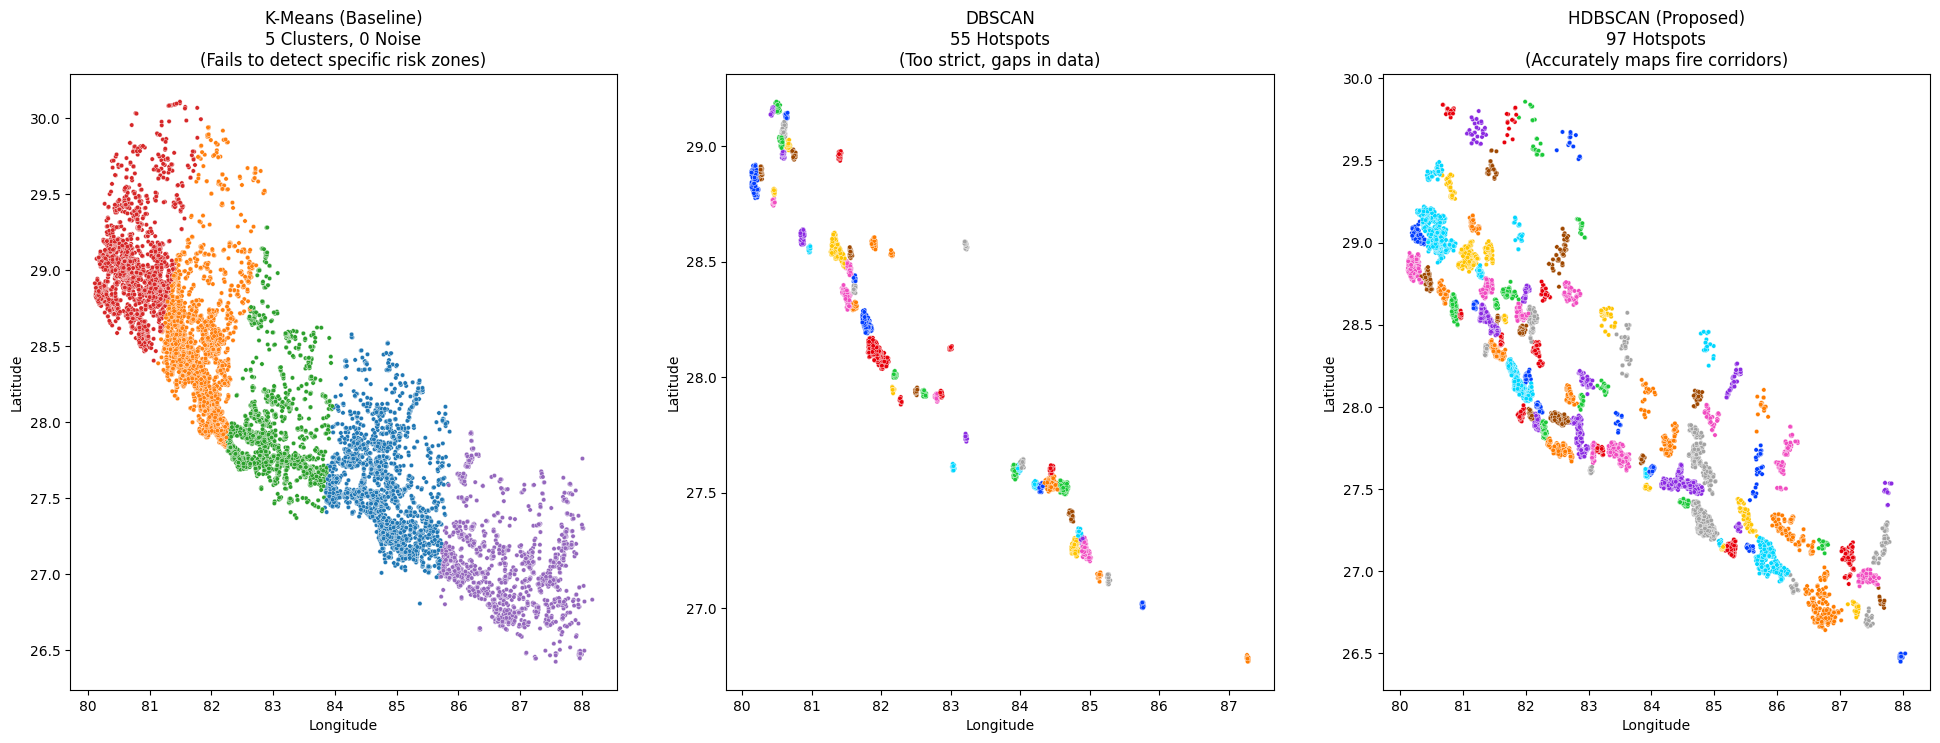

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# --- Plot 1: K-Means ---
# Note: K-Means uses 'tab10' palette to distinguish the 5 big zones
sns.scatterplot(data=df, x='longitude', y='latitude', hue='kmeans_cluster', 
                palette='tab10', s=10, legend=False, ax=axes[0])
axes[0].set_title(f"K-Means (Baseline)\n{n_clusters_kmeans} Clusters, 0 Noise\n(Fails to detect specific risk zones)")
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")

# --- Plot 2: DBSCAN ---
# We filter out noise (-1) to see the hotspots clearly
db_clean = df[df['dbscan_cluster'] != -1]
sns.scatterplot(data=db_clean, x='longitude', y='latitude', hue='dbscan_cluster', 
                palette='bright', s=10, legend=False, ax=axes[1])
axes[1].set_title(f"DBSCAN\n{n_clusters_db} Hotspots\n(Too strict, gaps in data)")
axes[1].set_xlabel("Longitude")
axes[1].set_ylabel("Latitude")

# --- Plot 3: HDBSCAN ---
hdb_clean = df[df['hdbscan_cluster'] != -1]
sns.scatterplot(data=hdb_clean, x='longitude', y='latitude', hue='hdbscan_cluster', 
                palette='bright', s=10, legend=False, ax=axes[2])
axes[2].set_title(f"HDBSCAN (Proposed)\n{n_clusters_hdb} Hotspots\n(Accurately maps fire corridors)")
axes[2].set_xlabel("Longitude")
axes[2].set_ylabel("Latitude")

plt.show()

Locate and save the file

In [9]:
import os

# Define the correct path
# We check if 'Data' exists in the current folder, if not we assume we are in 'notebooks'
if os.path.exists('Data'):
    save_path = 'Data/clustered_fires_nepal.csv'
elif os.path.exists('../Data'):
    save_path = '../Data/clustered_fires_nepal.csv'
else:
    # Fallback: Just save it right here so we don't lose it
    save_path = 'clustered_fires_nepal.csv'

# Save the DataFrame (which has the 'hdbscan_cluster' column)
df.to_csv(save_path, index=False)

print(f"SUCCESS: File saved to: {os.path.abspath(save_path)}")

SUCCESS: File saved to: c:\Users\pc\Desktop\ml assignment\Forest_Fire_Nepal\Data\clustered_fires_nepal.csv


Mathematical Validation (Silhouette Score)

In [ ]:
import pandas as pd
import os
from sklearn.metrics import silhouette_score

# --- 1. LOAD THE DATA (Fix for NameError) ---
# We check if 'df' exists. If not, we load the saved clustered file.
if 'df' not in locals():
    print("Variable 'df' missing. Loading saved data...")
    possible_paths = ['Data/clustered_fires_nepal.csv', '../Data/clustered_fires_nepal.csv']
    for path in possible_paths:
        if os.path.exists(path):
            df = pd.read_csv(path)
            print(f"SUCCESS: Loaded data from {path}")
            break

# --- 2. CALCULATE SILHOUETTE SCORE ---
if 'df' in locals() and 'hdbscan_cluster' in df.columns:
    print("Calculating Silhouette Score (this measures cluster quality)...")

    # Filter: Only use points that are in a cluster (Ignore Noise -1)
    valid_data = df[df['hdbscan_cluster'] != -1]
    
    if len(valid_data) > 0:
        valid_coords = valid_data[['lat_rad', 'lon_rad']]
        valid_labels = valid_data['hdbscan_cluster']

        # Calculate score (using Haversine metric for Earth distance)
        score = silhouette_score(valid_coords, valid_labels, metric='haversine')

        print(f"HDBSCAN Silhouette Score: {score:.4f}")

        # Interpretation
        if score > 0.5:
            print("CONCLUSION: Strong clustering structure (Distinct, dense hotspots).")
        elif score > 0.2:
            print("CONCLUSION: Moderate clustering (Expected for complex mountain terrain).")
        else:
            print("CONCLUSION: Weak clustering structure.")
    else:
        print("ERROR: No valid clusters found (all points are noise?). Check your parameters.")
else:
    print("CRITICAL ERROR: Could not find data. Please run the notebook from the top.")